In [1]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import glob
import os
import cv2
import random
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from detectron2.structures import BoxMode

from detectron2.engine import DefaultTrainer

from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

from detectron2.modeling import build_model
from detectron2.checkpoint import DetectionCheckpointer

/opt/conda/lib/python3.7/site-packages/IPython/utils/traitlets.py:5: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  warn("IPython.utils.traitlets has moved to a top-level traitlets package.")


In [2]:
def get_ead_dicts(img_dir):    
    images_path = os.path.join(img_dir, '*.jpg')
    images = glob.glob(images_path)
    
    dataset_dicts = []
    
    for idx, image_path in enumerate(images):
        text_path= image_path.replace(".jpg", ".txt")
        
        record = {}

        height, width = cv2.imread(image_path).shape[:2]
        
        record["file_name"] = image_path
        record["image_id"] = idx
        record["height"] = height
        record["width"] = width        
        
        with open(text_path) as f:
            contents = f.readlines()
        
        objs = []
        for content in contents:
            information = content.split(' ')
            
            obj = {
                "bbox": [(float(information[1]) - float(information[3]) / 2)*width, 
                         (float(information[2]) - float(information[4]) / 2)*height, 
                         (float(information[1]) + float(information[3]) / 2)*width, 
                         (float(information[2]) + float(information[4]) / 2)*height],
                "bbox_mode": BoxMode.XYXY_ABS,
                "category_id": int(information[0])
            }
            objs.append(obj)
                        
        record["annotations"] = objs
        dataset_dicts.append(record)                        
    return dataset_dicts

from detectron2.data import DatasetCatalog, MetadataCatalog

data_path = r'/home/ws2080/Desktop/codes/models/research/ead/data/'
train_path = r'/home/ws2080/Desktop/data/training/train/'
validation_path = r'/home/ws2080/Desktop/data/training/validation/'

'''
d= 'train'
DatasetCatalog.register("ead_train_1", lambda d=d: get_ead_dicts(train_path))
MetadataCatalog.get("ead_train_1").set(thing_classes=["specularity", "saturation", "artifact", "blur", "contrast", "bubbles", "instrument", "blood"])

'''

d= 'validation'
DatasetCatalog.register("ead_validation_1", lambda d=d: get_ead_dicts(validation_path))
MetadataCatalog.get("ead_validation_1").set(thing_classes=["specularity", "saturation", "artifact", "blur", "contrast", "bubbles", "instrument", "blood"])

Metadata(name='ead_validation_1', thing_classes=['specularity', 'saturation', 'artifact', 'blur', 'contrast', 'bubbles', 'instrument', 'blood'])

In [3]:
model_path = 'output'
checkpoints = ['0009999',
               '0019999',
               '0029999',
               '0039999',
               '0049999',
               '0059999',
               '0069999',    
               '0079999',               
               '0089999']

'''
'0099999'
'0109999', 
'0119999', 
'0129999',
'0139999',
'0149999',
'0159999',
'0169999',
'0179999',
'0189999',
'0199999'
]
'''

"\n'0099999'\n'0109999', \n'0119999', \n'0129999',\n'0139999',\n'0149999',\n'0159999',\n'0169999',\n'0179999',\n'0189999',\n'0199999'\n]\n"

In [4]:
APs =[]
AP50s = []
AP75s = []

In [5]:
for checkpoint in checkpoints:
    print("-------------------------> " + checkpoint)
    cfg = get_cfg()

    cfg.merge_from_file("output/config.yaml")
    model = build_model(cfg)
    DetectionCheckpointer(model).load("output/model_"+checkpoint+".pth")
    
    evaluator = COCOEvaluator("ead_validation_1", cfg, False, output_dir="./output/")
    val_loader = build_detection_test_loader(cfg, "ead_validation_1")
    a = inference_on_dataset(model, val_loader, evaluator)
    
    APs.append(a.get('bbox')['AP'])
    AP50s.append(a.get('bbox')['AP50'])
    AP75s.append(a.get('bbox')['AP75'])
    

WARNING [03/02 11:21:31 d2.evaluation.coco_evaluation]: json_file was not found in MetaDataCatalog for 'ead_validation_1'
[03/02 11:21:31 d2.data.datasets.coco]: Cached annotations in COCO format already exist: ./output/ead_validation_1_coco_format.json
[03/02 11:21:33 d2.data.build]: Distribution of instances among all 8 categories:
|  category   | #instances   |  category  | #instances   |  category  | #instances   |
|:-----------:|:-------------|:----------:|:-------------|:----------:|:-------------|
| specularity | 1399         | saturation | 173          |  artifact  | 969          |
|    blur     | 96           |  contrast  | 224          |  bubbles   | 622          |
| instrument  | 62           |   blood    | 53           |            |              |
|    total    | 3598         |            |              |            |              |
[03/02 11:21:33 d2.evaluation.evaluator]: Start inference on 300 images
[03/02 11:21:33 d2.evaluation.evaluator]: Inference done 11/300. 0.031

[03/02 11:22:29 d2.evaluation.coco_evaluation]: Per-category bbox AP: 
| category    | AP     | category   | AP     | category   | AP     |
|:------------|:-------|:-----------|:-------|:-----------|:-------|
| specularity | 6.177  | saturation | 23.369 | artifact   | 17.364 |
| blur        | 34.093 | contrast   | 39.415 | bubbles    | 10.128 |
| instrument  | 66.347 | blood      | 11.238 |            |        |
[03/02 11:22:31 d2.evaluation.evaluator]: Start inference on 300 images
[03/02 11:22:31 d2.evaluation.evaluator]: Inference done 11/300. 0.0309 s / img. ETA=0:00:09
[03/02 11:22:36 d2.evaluation.evaluator]: Inference done 168/300. 0.0306 s / img. ETA=0:00:04
[03/02 11:22:41 d2.evaluation.evaluator]: Total inference time: 0:00:09.533062 (0.032315 s / img per device, on 1 devices)
[03/02 11:22:41 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:09 (0.030779 s / img per device, on 1 devices)
[03/02 11:22:41 d2.evaluation.coco_evaluation]: Preparing results for COC

[03/02 11:23:25 d2.evaluation.evaluator]: Start inference on 300 images
[03/02 11:23:26 d2.evaluation.evaluator]: Inference done 11/300. 0.0327 s / img. ETA=0:00:09
[03/02 11:23:31 d2.evaluation.evaluator]: Inference done 168/300. 0.0305 s / img. ETA=0:00:04
[03/02 11:23:35 d2.evaluation.evaluator]: Total inference time: 0:00:09.444027 (0.032014 s / img per device, on 1 devices)
[03/02 11:23:35 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:08 (0.030471 s / img per device, on 1 devices)
[03/02 11:23:35 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[03/02 11:23:35 d2.evaluation.coco_evaluation]: Saving results to ./output/coco_instances_results.json
[03/02 11:23:35 d2.evaluation.coco_evaluation]: Evaluating predictions ...
Loading and preparing results...
DONE (t=0.08s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=4.84s).
Accumulating evaluation results...
DONE (t=0.27s).
 Average Prec

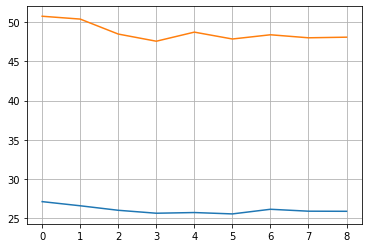

In [10]:
plt.grid(True)
plt.plot(APs)
plt.plot(AP50s)

In [7]:
APs

[27.11970322623286,
 26.59079723014172,
 26.01635025895878,
 25.640825753182302,
 25.72877803741555,
 25.55363437130969,
 26.146248195991777,
 25.9008371934243,
 25.88763804388933]

In [8]:
AP50s

[50.744396266427984,
 50.38235630204665,
 48.473573976603774,
 47.562074755695356,
 48.72002845766375,
 47.84418549242015,
 48.383675813494406,
 47.99780556971995,
 48.076151015158466]

In [9]:
AP75s

[24.39066571521305,
 24.28661023875462,
 24.089207900779837,
 23.947010399791267,
 23.402557063036973,
 23.34886824583941,
 23.66353294782925,
 23.804181357168495,
 23.736164253915067]